## Contents


# Setup

To view this notebook, I used the following steps:
  * install [Anaconda](https://www.continuum.io/downloads) with default Python 3 environment
  * you should now be able to open this notebook (`jupyter notebook` launches jupyter and opens a browser)

The notebook uses a number of default Python libraries (e.g., numpy, matplotlib) which come in default anaconda installations. It also uses a library we are developing for use with neural data, [nelpy](https://github.com/eackerman/nelpy). To install nelpy, you should be able to `pip install nelpy` from a terminal window.


# Introduction

To support adaptive behavior, activity in the brain must correspond in some way to relevant sensory events and planned movements, combine many sources of information into multimodal percepts, and recall traces of past events to inform predictions about the future. In other words, neural activity must somehow *encode* relevant quantities. For instance, it can be demonstrated behaviorally that many animals use estimates of their location and head direction to navigate towards a goal. Where, and how, are these quantities represented in the brain? What are the neural circuits that can compute and update these signals? How do place and direction estimates contribute to which way to go? _Decoding_ approaches can help address such questions, and many more besides.

To develop an intuition for how decoding works, consider Hubel and Wiesel's demonstration that single cells in macaque V1 respond to bars of light not only within a particular region of visual space, but also with a specific orientation. Such cells are said to be tuned for orientation (of the bar) and a typical _tuning curve_ would therefore look like this:

![Tuning curve](images/hubel_wiesel_tc.png)

This tuning curve describes how the cell responds, on average, to different orientations of the stimulus. If the cell were to respond with the same firing rate across the range of stimulus orientations, then the cell is indifferent to this particular stimulus dimension: it does not encode it. However, because this cell clearly modulates its firing rate with stimulus orientation, it encodes, or represents (I use these terms interchangeably, but some disagree) this quantity in its activity.

We can turn this idea around and note that if orientation is encoded, this implies we can also decode the original stimulus from the cell's activity. For instance, if we noted that this cell was firing at a high rate, we would infer that the stimulus orientation is likely close to the cell's preferred direction. Note that this requires knowledge of the cell's tuning curve, and that based on one cell only, we are unlikely to be able to decode (or reconstruct, which means the same thing) the stimulus perfectly. The more general view is to say that the cell's activity provides a certain amount of information about the stimulus, or equivalently, that our (decoded) estimate of the stimulus is improved by taking the activity of this cell into account.

This module first explores some practical issues in estimating tuning curves of “place cells” recorded from the rat hippocampus. An introduction to a particular decoding method (Bayesian decoding) is followed by application to many simultaneously recorded place cells as a rat performs a T-maze task, described in [van der Meer et al. (2017)](http://onlinelibrary.wiley.com/doi/10.1002/hipo.22714/full).

In [12]:
##compare nept/nelpy

import numpy as np # primary math library
import matplotlib.pyplot as plt # primary plotting library
%matplotlib inline

import nelpy as nel # should be installed using pip install nelpy

import warnings
#warnings.filterwarnings("ignore") # useful to prevent excess nelpy warnings

# Setup continued

Finally, you'll need the data we use for this notebook. The source for this data is the CRCNS.org neural data repository, where it was deposited by the laboratory of Loren Frank. A large compressed archive can be found [here](http://ec2-54-202-16-78.us-west-2.compute.amazonaws.com/FrankLabData.nel). You should download it into a data directory. We then need to set the data location.

In [13]:
dataroot =r'C:\Users\asus\OneDrive - Dartmouth College\mind_2017\TEST DATA';

# Loading and inspecting the data

Next, we load the spike and position data. These have been stored the 'FrankLabPickle.npz' file. You can load it using numpy.load. The data are in a dictionary called `data`, organized by animal nickname, experiment day, and data type (`pos` or `spikes`).

In [14]:
#SE inserted this on 9 Sept to help figure out what causes errors
import os, sys
print("Current working dir : ", os.getcwd())

Current working dir :  C:\Users\asus\OneDrive - Dartmouth College\mind_2017\Tutorials\SpikeDecoding


In [15]:
import os

filename = os.path.join(dataroot,'FrankLabData.nel')
#import pandas as pd
import nelpy.io
jar = nel.load_pkl(filename)



In [16]:
data = jar.data
# if you are interested in the global task structure or characteristics of all the neurons 
#     recorded, they can be found in Pandas dataframes which are also saved in the file
# taskinfo = savedata['taskinfo']
# cellinfo = savedata['cellinfo']


##SE notes 9 Sept. No _accessors file found in nelpy. ??
## nevermind SE is an idiot. fixed 10 Sept.

In [17]:
## print(data.keys()) # Animals in the archive
# The animal "Bon" had good data on day 3
S = data['Bon'][3]['spikes']
pos = data['Bon'][3]['pos']
# Bon day 3 also good, could try frank day 7 too


The Frank Lab archive does not distinguish between the quality of sorted cells. In general, you would not want to use  neurons which were not well-sorted to make claims about single neuron properties; however, for this analysis we are not concerned with properties of individual neurons. We are instead interested in the information present in a population of neurons, and for this we will take everything we can get!

In these data, there are multiple runs each day in different mazes. (You can find out the the description of these runs by looking in the taskinfo dataframe, i.e., `jar.taskinfo.query('Animal=="Bon" & Day==3')`.) We're interested in spatial coding, so we want to look only at the data taken while running in the same maze. For the example of Bon/day 3, epochs 2 and 4 are runs in "TrackB".

In [18]:
jar.taskinfo.query('Animal=="Bon" & Day==3')

,Animal,Day,Epoch,type,exposure,environment,description,sleepnum,dailyexposure,exposureday,experimentday,tracksexperienced,dailytracksexperienced,linearcoord
42,Bon,3,0,sleep,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN
43,Bon,3,1,run,3.0,TrackB,TrackB,NaN,1.0,2.0,8.0,2.0,1.0,[[[[217.64976959 217.64976959 217.64976959 ......
44,Bon,3,2,sleep,NaN,NaN,NaN,2.0,NaN,NaN,NaN,NaN,NaN,NaN
45,Bon,3,3,run,4.0,TrackB,TrackB,NaN,2.0,2.0,8.0,2.0,1.0,[[[[217.92626728 217.92626728 217.92626728 ......
46,Bon,3,4,sleep,NaN,NaN,NaN,3.0,NaN,NaN,NaN,NaN,NaN,NaN
47,Bon,3,5,run,14.0,TrackA,TrackA,NaN,1.0,8.0,8.0,2.0,2.0,[[[[141.33640553 141.33640553 141.33640553 ......
48,Bon,3,6,sleep,NaN,NaN,NaN,4.0,NaN,NaN,NaN,NaN,NaN,NaN


For time series variables, the `nelpy` library incorporates a concept of **temporal support** (i.e., periods during which data are defined). This is defined using the  `EpochArray` type. For the position data, the different sleep, run epochs define a 7 member `EpochArray`, which can be accessed using `pos.support`.

In [19]:
print(pos.support)
print(pos.support.time)

##gives time intervals during which data is defined

<EpochArray at 0x21983bc8320: 7 epochs> of length 1:59:18:060 hours
[[1006.05       2343.00343333]
 [2461.0113     3405.01263333]
 [3483.7202     4426.99883333]
 [4564.0273     5501.02203333]
 [5579.2946     6811.00603333]
 [7394.6642     8326.01983333]
 [8514.2402     9348.00533333]]


### Using temporal support in nelpy
The position data is of type `AnalogSignalArray`, which `nelpy` uses for time series data. In this case, the two "channels" correspond to the x and y position dimensions. Note that an `AnalogSignalArray` is not just a simple numpy array (though you can access the data that way). Rather, the two dimensions of slicing for `AnalogSignalArrays` are `epoch` and `channel`. This means that `asa[[2,4]]` corresponds to data during the 3rd and 5th epochs in the support of asa, `asa[:,3:6]` corresponds to data from all epochs from the 4th through 7th channels, and `asa[[2,4],3:6]` implies both conditons. *(Remember that Python is 0 indexed rather than 1 indexed like Matlab!)*
 
Let's get the position for the two runs and plot them.

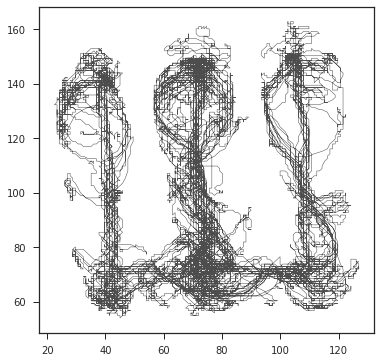

In [20]:
import nelpy.plotting as npl
# Set default figure aesthetics
npl.setup(font_scale=1)

with npl.FigureManager(show=True, figsize=(6, 6)) as (fig, ax):
    npl.utils.skip_if_no_output(fig)

    tvals, vals = pos[[1,3],:].asarray() # Access timestamps and channel data as numpy arrays
    xvals, yvals = vals # Access two channels as x and y
    ax.plot(xvals, yvals, lw=0.5, c='0.3')
##This plots position for the two runs on the same maze

In these sets of experiments, spike sorting was done combining all sessions in a day. We store the spike times for each neuron in a nelpy `SpikeTrainArray` object. `SpikeTrainArray` is a similar structure to `AnalogSignalArray` in that it has an `EpochArray` as support, and can be sliced. The slicing for a `SpikeTrainArray` object is slightly different, however. The first dimension is still epochs. The second dimension has numeric labels (UnitIds) - this allows information about neurons to be preserved while still allowing for things like reordering for presentation. To index using the UnitId labels, use `sta.loc[]`, but if you just want to index by position use `sta.iloc[]`. For example, if you want to select the first 10 units, you should use `sta.iloc[:,:10]`, but if you want UnitIDs 1 and 5, you can use `sta.loc[:,[1,5]]` regardless of whether the order of the units has been changed or some have been removed.

Now we can plot the position data (location of the rat as it runs the maze, in gray), and the position of the rat when an example neuron fired a spike (in red). We'll use a fun `AnalogSignalArray` feature, **the `at` option for support**.

In [9]:
hasattr('SpikeTrainArray','_restrict')
##SE added this 10 Sept

False

In [10]:
##SE added this 10 Sept
dir('SpikeTrainArray')

['__add__',
 '__class__',
 '__contains__',
 '__delattr__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__getitem__',
 '__getnewargs__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__iter__',
 '__le__',
 '__len__',
 '__lt__',
 '__mod__',
 '__mul__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__rmod__',
 '__rmul__',
 '__setattr__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 'capitalize',
 'casefold',
 'center',
 'count',
 'encode',
 'endswith',
 'expandtabs',
 'find',
 'format',
 'format_map',
 'index',
 'isalnum',
 'isalpha',
 'isascii',
 'isdecimal',
 'isdigit',
 'isidentifier',
 'islower',
 'isnumeric',
 'isprintable',
 'isspace',
 'istitle',
 'isupper',
 'join',
 'ljust',
 'lower',
 'lstrip',
 'maketrans',
 'partition',
 'replace',
 'rfind',
 'rindex',
 'rjust',
 'rpartition',
 'rsplit',
 'rstrip',
 'split',
 'splitlines',
 'startswith',
 'strip',
 'swapcase',
 'title',
 'translate',
 'upper',


In [21]:
unit_id = 15 # 18 for day 3
_, pos_at_spikes = pos.asarray(at=S[[1],unit_id].time.squeeze())
print(pos_at_spikes.shape)

with npl.FigureManager(show=True, figsize=(6, 6)) as (fig, ax):
    npl.utils.skip_if_no_output(fig)
    tvals, vals = pos[[1],:].asarray() # Access timestamps and channel data as numpy arrays
    xvals, yvals = vals # Access two channels as x and y
    ax.plot(xvals, yvals, lw=0.5, c='0.8')
    ax.plot(pos_at_spikes[0,:], pos_at_spikes[1,:], 'r.')

AttributeError: 'SpikeTrainArray' object has no attribute '_restrict'

### How does the `at` option work?

The `at` option is a convience wrapper which creates a scipy.interpolate.interp1d() and then calls it. In this case this amounts to something like
```
from scipy import interpolate
tnew = S[[1,3],unit_id].time
t,x = pos.asarray()
f = interpolate.interp1d(x=t, y=x, axis=-1, kind='linear', copy=True, bounds_error=False)
xnew = f(tnew)

```
This cell seems to have a place field on the corner leading to the left arm of the maze. There are also a few spikes at the ends of the maze, where the rat receives his reward as he alternates on the track.

# Estimating tuning curves

This figure is a useful visualization of the raw data, but it is not a tuning curve, which captures the relationship between a variable of interest (e.g. position) to firing rate. A set of tuning curves can be thought of as an *encoding model* that specifies how the position variable is encoded by our population of place cells. As a first step to estmiating this model, we restrict our data to those times the rat is actually running on the track. **Note the use of the complement of an EpochArray in the second figure.** We were required to create a new variable defined just over the two run epochs `([1,3])`, so that the domain of the support would be properly defined for the complement. (Try what happens if you don't do this to see how it pulls in position data from other epochs!)

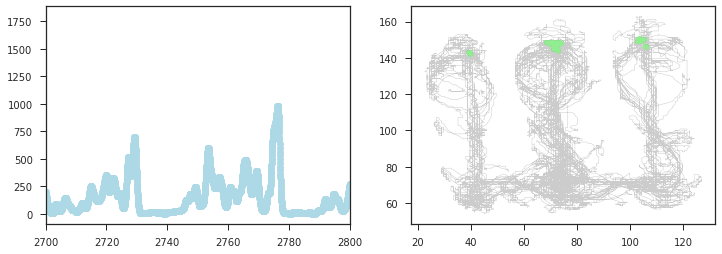

In [12]:
# Begin by calculating a smoothed derivative. We use a nelpy wrapper function dxdt_AnalogSignalArray().
# This calls numpy.norm(numpy.gradient) for 2D signals such as our pos variable.
# numpy.gradient is nice because it's centered in time as opposed to numpy.diff, which is a forward derivative.
sigma_500ms = 0.5
speed = nel.utils.ddt_asa(pos[[1],:], smooth=True, sigma=sigma_500ms)
speed.data = (speed.data**2).sum(axis=0,keepdims=True)

# get_run_epochs is a utility function which wraps a speed threshold. This finds periods where the speed
#   is greater than v2 and reaches at least a maximum of v1.
run_epochs = nel.utils.get_run_epochs(speed, v1=8, v2=3) # original choice

with npl.FigureManager(show=True, figsize=(12,4), nrows=1, ncols=2) as (fig, axes):
    ax, ax1 = axes
    npl.utils.skip_if_no_output(fig)
    tvals, vals = speed.asarray() # Access timestamps and channel data as numpy arrays
    ax.plot(tvals, vals, '.', lw=1, c='0.3')
    tvals2, vals2 = speed[run_epochs,:].asarray() # Access timestamps and channel data as numpy arrays
    ax.plot(tvals2, vals2, 'o', color='lightblue')
    ax.set_xlim([2700,2800])
    
    # Plot 2D data for the complement of the run epochs. 
    tvals, vals = pos[[1,3],:].asarray() # Access timestamps and channel data as numpy arrays
    xvals, yvals = vals # Access two channels as x and y
    ax1.plot(xvals, yvals, lw=0.5, c='0.8')
    pos_run = pos[[1],:]
    tvals2, vals2 = pos_run[~run_epochs,:].asarray() # Access timestamps and channel data as numpy arrays
    xvals2, yvals2 = vals2 # Access two channels as x and y
    ax1.plot(xvals2, yvals2, '.', color='lightgreen')


The `nelpy` plotting routines include a very nice raster plot function as well as functions which
make it easy to color in different epochs. Lets show all of our spikes, with a light blue window
over run periods.

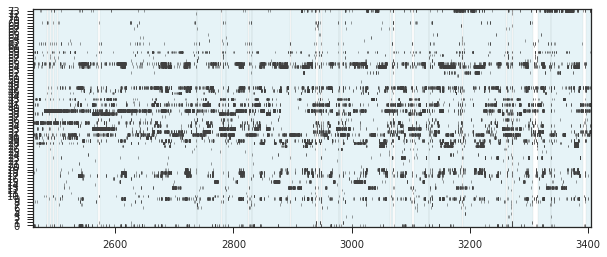

In [13]:
with npl.FigureManager(show=True, figsize=(10,4)) as (fig, ax):
    npl.utils.skip_if_no_output(fig)
    npl.rasterplot(S[[1,3],:], lw=0.5, ax=ax)
    npl.epochplot(run_epochs, fc='lightblue', alpha=0.3)
    ax.set_xlim(*pos.support[1].time)

In [15]:
# Calculate run epochs for both sessions in the same maze
sessions = [1,3]
all_run_epochs = nel.EpochArray()
for s in sessions:
    _speed = nel.utils.ddt_asa(pos[[s],:], smooth=True, sigma=sigma_500ms)
    _speed.data = (speed.data**2).sum(axis=0,keepdims=True)

    _run_epochs = nel.utils.get_run_epochs(speed, v1=8, v2=3) # original choice
    all_run_epochs += _run_epochs


### Binned spike trains
We will calculate tuning curves using binned spike trains. This is not necessary (and, in the 1D
case, tuning curve estimation is easy without it). However, if we want to smooth the spike trains, 
binning makes this much more easy. `nelpy` includes a `BinnedSpikeTrain` class, which is a special
time series for spike trains. Below, we bin spikes into narrow time windows, smooth with a Guassian
kernel, and then rebin into larger timebins. The `nelpy` functions are careful to just bin/smooth in
defined epochs, respecting epoch boundaries.

In [16]:
st_run = S[all_run_epochs]

# Bin sizes are 500 ms, and then we sli 
ds_run = 0.250 # 250 ms
ds_50ms = 0.05

# bin, smooth and re-bin:
sigma = 0.3 # 300 ms spike smoothing
bst_run = st_run.bin(ds=ds_50ms).smooth(sigma=sigma, inplace=True).rebin(w=ds_run/ds_50ms)


### Estimating tuning curves
Now, we can compute tuning curves for each of our cells. The `TuningCurves()` function does this in three steps:
  * Compute an *occupancy* histogram (amount of time spent in each 2-D bin)
  * Compute a *spike* histogram (count number of spikes fired in each 2-D bin) - we'll do this for smoothed/binned spike trains
  * Compute firing rates by dividing the spike count by the occupancy

The below code plots the output of the third step for our example cell:

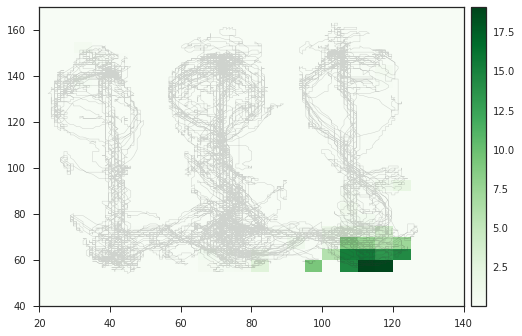

In [17]:
# Bins for tuning curves
x_extents = [20,140] # Read these off of maze figure above
nx = np.diff(x_extents)/5 # plan for 5 cm bins

y_extents = [40,170]
ny = np.diff(y_extents)/5

min_duration = 1 # require that estimation periods be at least 1 second long

tc = nel.TuningCurve2D(bst=bst_run, extern=pos, 
                       ext_xmin=x_extents[0], ext_xmax=x_extents[1], 
                       ext_ymin=y_extents[0], ext_ymax=y_extents[1],
                       ext_nx=nx, ext_ny=ny,
                       min_duration=min_duration)

placefield = tc.ratemap[unit_id].T
ax, img = npl.imagesc(x=tc.xbin_centers, y=tc.ybin_centers, 
                      data=placefield,
                      cmap=plt.cm.Greens)
ax.plot(xvals, yvals, lw=0.5, c='0.2', alpha=0.2)
#ax.plot(pos_at_spikes[0,:], pos_at_spikes[1,:], '.', color='tomato', alpha=0.25)

# Tinker to get the colorbar in the right place
from mpl_toolkits.axes_grid1 import make_axes_locatable
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="3.5%", pad=0.1)
cb=plt.colorbar(img, cax=cax)
npl.utils.no_yticks(cax)


#import scipy
#smoothpf = scipy.ndimage.filters.gaussian_filter(placefield, sigma=(1,1), truncate=4)


### Smoothing tuning curves
As can be seen from the plot above, the (arbitrary) binning results in a noisy-looking tuning curve. As shown in van der Meer et al. (2017) applying some judicious smoothing can increase decoding accuracy substantially. This smoothing is kind of a hack, and can be viewed as an approximation of a more principled estimation process that starts with a prior on the likely shape of single cell tuning curves which is then updated using the encoding data. For now, we'll just do what works:

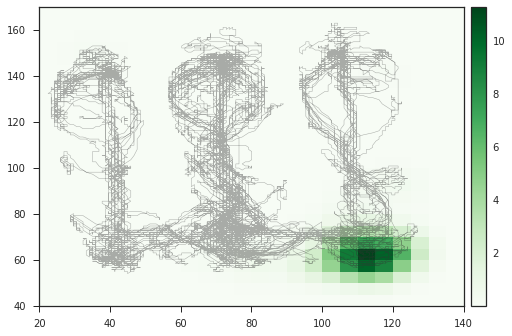

In [18]:
# Smoothing standard deviation
sigma = 5 # tuning curve smoothing std in cm

tc = nel.TuningCurve2D(bst=bst_run, extern=pos, 
                       ext_xmin=x_extents[0], ext_xmax=x_extents[1], 
                       ext_ymin=y_extents[0], ext_ymax=y_extents[1],
                       ext_nx=nx, ext_ny=ny,
                       sigma=sigma, min_duration=1)

placefield = tc.ratemap[unit_id].T
ax, img = npl.imagesc(x=tc.xbin_centers, y=tc.ybin_centers, 
                      data=placefield,
                      cmap=plt.cm.Greens)
ax.plot(xvals, yvals, lw=0.5, c='0.2', alpha=0.4)
#ax.plot(pos_at_spikes[0,:], pos_at_spikes[1,:], '.', color='dodgerblue', alpha=0.25)

# Tinker to get the colorbar in the right place
from mpl_toolkits.axes_grid1 import make_axes_locatable
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="3.5%", pad=0.1)
cb=plt.colorbar(img, cax=cax)
npl.utils.no_yticks(cax)

LoadMetadata; % loads experimenter-annotated file associated with each data session

% ENCoding variables: used for estimating tuning curves (encoding model)
ENC_S = restrict(S,metadata.taskvars.trial_iv); % trial_iv contains the start and end times of trials
ENC_pos = restrict(pos,metadata.taskvars.trial_iv);
 
% check for empties and remove
keep = ~cellfun(@isempty,ENC_S.t);
ENC_S = SelectTS([],ENC_S,keep);

% also set up DECoding variables for use later
DEC_S = SelectTS([],S,keep);

You can inspect the tuning curves of all cells as follows:

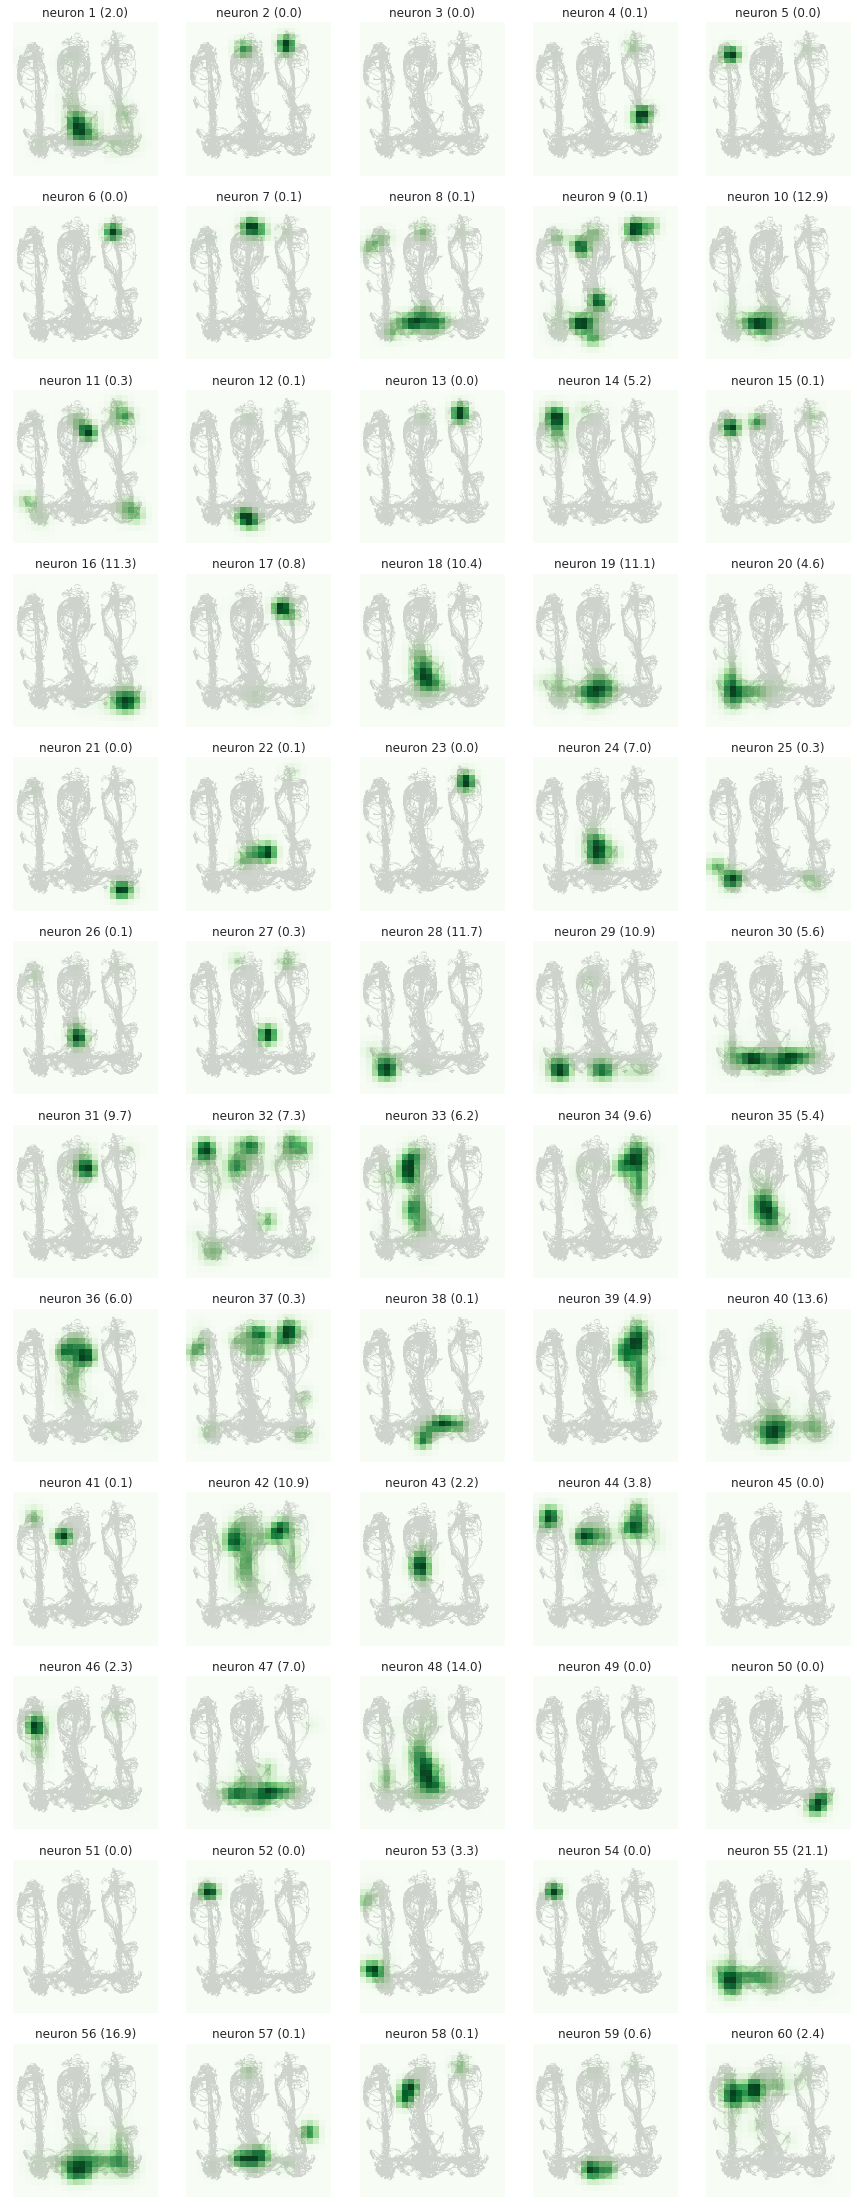

In [20]:
n_units = S.n_units
with npl.FigureManager(show=True, figsize=(15, 40), nrows=12, ncols=5) as (fig, axes):
    #npl.utils.skip_if_no_output(fig)
    for ii, ax in enumerate(axes.ravel()):
        if (ii >= n_units):
            break
        placefield = tc.ratemap[ii].T
        ax, img = npl.imagesc(x=tc.xbin_centers, y=tc.ybin_centers, 
                              data=placefield,
                              cmap=plt.cm.Greens,
                              ax=ax)
        ax.plot(xvals, yvals, lw=0.5, c='0.2', alpha=0.2)
        ax.set_title('neuron {} ({:3.1f})'.format(ii+1, placefield.max()))
        npl.utils.clear_left_right(ax)
        npl.utils.clear_top_bottom(ax)

You will see a some textbook “place cells” with a clearly defined single place field. There are also cells with other firing patterns.

This notebook computes tuning curves for location, but the idea is of course more general. For continuous variables in particular, it is a natural and powerful way to describe the relationship between two quantities – spikes and location in this case, but there is no reason why you couldn't do something like pupil diameter as a function of arm reaching direction, for instance!

**Note:** The `tc` object returned by `TuningCurve2D()` contains a number of other fields in addition to the actual tuning curves plotted above. One very useful field is `tc.occupancy`. Later, we will need to parse bins by occupancy in order to speed up decoding computations. In a nutshell, we will want to only consider spatial bins with sufficient sampling (occupancy). In addition, you can find the boundaries of the x and y axis bins (`tc.xbins`, `tc.ybins`) as well as bin
centers, which we've already used for plotting. Spatial information and spatial sparsity can also be calculated to look for place-iness.

# Bayesian decoding

As noted in the introduction above, given that we have neurons whose activity seems to encode some stimulus variable (location in this case, as evident from the tuning curves above), we can attempt to decode that variable based on the neurons' time-varying activity.

A popular approach to doing this is “one-step Bayesian decoding”, illustrated in this figure (from <a href="http://www.cell.com/neuron/abstract/S0896-6273(10)00507-6">van der Meer et al. 2010</a>):

![Decoding schematic](images/mvdm_yorkfieldtrip13.png)

For this particular experiment, the goal of decoding is to recover the location of the rat, given neural activity in some time window. More formally, we wish to know $P(\mathbf{x}|\mathbf{n})$, the probability of the rat being at each possible location $x_i$ ($\mathbf{x}$ in vector notation, to indicate that there are many possible locations) given a vector of spike counts $\mathbf{n}$.

If $P(\mathbf{x}|\mathbf{n})$ (the "posterior") is the same for every location bin $x_i$ (i.e. is uniform), that means all locations are equally likely and we don't have a good guess; in contrast, if most of the $x_i$ are zero and a small number have a high probability, that means we are confident predicting the most likely location. Of course, there is no guarantee that our decoded estimate will agree with the actual location; we will test this later on.

So how can we obtain $P(\mathbf{x}|\mathbf{n})$? We can start with Bayes' rule:

$P(\mathbf{x}|\mathbf{n})P(\mathbf{n}) = P(\mathbf{n}|\mathbf{x})P(\mathbf{x})$

If you have not come across Bayes' rule before, or the above equation looks mysterious to you, review the gentle intro by linked to at the top of the page. In general, it provides a quantitative way to update prior beliefs in the face of new evidence.

The key quantity to estimate is $P(\mathbf{n}|\mathbf{x})$, the probability of observing $n$ spikes in a given time window when the rat is at location $x$. At the basis of estimating this probability (the "likelihood" or evidence) lies the tuning curve: this tells us the _average_ firing rate at each location. We need a way to convert a given number of spikes -- whatever we observe in the current time window for which we are trying to decode activity, 3 spikes for cell 1 in the figure above -- to a probability. In other words, what is the probability of observing 3 spikes in a 250ms time window, given that for this location the cell fires, say at 5Hz on average?

A convenient answer is to assume that the spike counts follow a Poisson distribution. Assuming this enables us to assign a probability to each possible spike count for a mean firing rate given by the tuning curve. For instance, here are the probabilities of observing different numbers of spikes $k$ (on the horizontal axis) for four different means ($\lambda = $1, 4 and 10):

![Poisson distro](https://upload.wikimedia.org/wikipedia/commons/thumb/1/16/Poisson_pmf.svg/500px-Poisson_pmf.svg.png)

In general, from the [definition of the Poisson distribution](http://en.wikipedia.org/wiki/Poisson_distribution), it follows that

$P(n_i|\mathbf{x}) = \frac{(\tau f_i(\mathbf{x}))^{n_i}}{n_i!} e^{-\tau f_i (x)}$

$f_i(\mathbf{x})$ is the average firing rate of neuron $i$ over $x$ (i.e. the tuning curve for position), $n_i$ is the number of spikes emitted by neuron $i$ in the current time window, and $\tau$ is the size of the time window used. Thus, $\tau f_i(\mathbf{x})$ is the mean number of spikes we expect from neuron $i$ in a window of size $\tau$; the Poisson distribution describes how likely it is that we observe the actual number of spikes $n_i$ given this expectation.

In reality, place cell spike counts are [typically not Poisson-distributed](http://www.ncbi.nlm.nih.gov/pubmed/9501237) so this is clearly a simplifying assumption. There are many other, more sophisticated approaches for the estimation of $P(n_i|\mathbf{x})$ (see for instance [Paninski et al. 2007](http://www.ncbi.nlm.nih.gov/pubmed/17925266)) but this basic method works well for many applications.

The above equation gives the probability of observing $n$ spikes for a given average firing rate for a single neuron. How can we combine information across neurons? Again we take the simplest possible approach and assume that the spike count probabilities for different neurons are independent. This allows us to simply multiply the probabilities together to give:

$P(\mathbf{n}|\mathbf{x}) = \prod_{i = 1}^{N} \frac{(\tau f_i(\mathbf{x}))^{n_i}}{n_i!}
e^{-\tau f_i (x)}$

An analogy here is simply to ask: if the probability of a coin coming up heads is $0.5$, what is the probability of two coints, flipped simultaneously, coming up heads? If the coins are independent then this is simply $0.5*0.5$.

Combining the above with Bayes' rule, and rearranging a bit, gives

$P(\mathbf{x}|\mathbf{n}) = C(\tau,\mathbf{n}) P(\mathbf{x}) (\prod_{i = 1}^{N} f_i(\mathbf{x})^{n_i}) \: e (-\tau \sum_{i = 1}^N f_i(\mathbf{x}))$

This is more easily evaluated in vectorized MATLAB code. $C(\tau,\mathbf{n})$ is a normalization factor which we simply set to guarantee $\sum_x P(\mathbf{x}|\mathbf{n}) = 1$ (Zhang et al. 1998). For now, we assume that $P(\mathbf{x})$ (the "prior") is uniform, that is, we have no prior information about the location of the rat and let our estimate be completely determined by the likelihood.

The tuning curves take care of the $f_i(x)$ term in the decoding equations. Next, we need to get $\mathbf{n}$, the spike counts.

## Obtaining the Q-matrix

This “Q-matrix” is of size [nCells x nTimeBins] and contains the spike count for each neuron in a given time bin. We've alreayd calculated this above as `bst_run`!

AttributeError: 'AxesSubplot' object has no attribute '_hold'

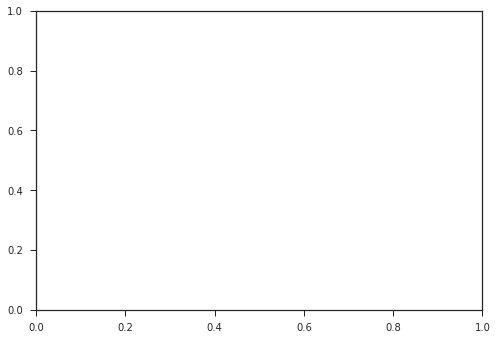

In [21]:
ax, img = npl.imagesc(x=bst_run.centers,y=range(n_units), data=bst_run.data,
                      cmap=plt.cm.seismic, large=True)


In [22]:
hasattr('AxesSubplot','_hold')
##SE added this 12 Sept

False

Each column of this matrix is a vector of spike counts ($\mathbf{n}$ in the section above). You can use the interactive features in the [plotly](https://plot.ly/~mvdm/8/) version to zoom in to specific columns in the above plot.

Note that this type of matrix is shared by many different kinds of data in neuroscience -- this one contains binned spike counts, but a similar matrix can be constructed for spike density functions (firing rates), BOLD signals for voxels measured by fMRI, calcium levels from fluorescent microscopy, and so on. Analyses such as representational similarity analysis, functional and effective connectivity, discovery of network structure (hubs, ensembles, cliques, etc.) take a matrix of this type as a starting point. 

## Running the decoding algorithm

For the purposes of this tutorial, this matrix completes the set of ingredients required to perform decoding. Although the codebase provides configurable [wrapper functions](https://github.com/vandermeerlab/vandermeerlab/tree/b0d349b1f78b47b272f26c618e0235c97ef40f4a/code-matlab/shared/proc/Decoding) for this, a minimal version of the raw code follows below so you can see how it works:

In [17]:
np.sum(tc.ratemap.max(axis=(1,2)) > 0.5)

32

In [18]:
# First, let's limit ourselves to neurons which have some firing on the track
ActiveThreshold = 0.5 # spikes/second
activeNeurons = np.argwhere(tc.ratemap.max(axis=(1,2)) > ActiveThreshold).squeeze()
print('Number of active neurons: {}.'.format(activeNeurons.shape[0]))


Number of active neurons: 32.


In [19]:
# Subselect data and ratemap by active neurons:

# Regenerate binnedspikearray as workaround for slicing not yet being implemented
spike_sigma = 0.3 # 300 ms spike smoothing

Q = S[[1,3],activeNeurons].bin(ds=ds_50ms).smooth(sigma=spike_sigma, inplace=True).rebin(w=ds_run/ds_50ms)
#Q = st_run[:,activeNeurons].bin(ds=ds_50ms).smooth(sigma=sigma, inplace=True).rebin(w=ds_run/ds_50ms)

ratemap = tc.ratemap[activeNeurons,:,:]


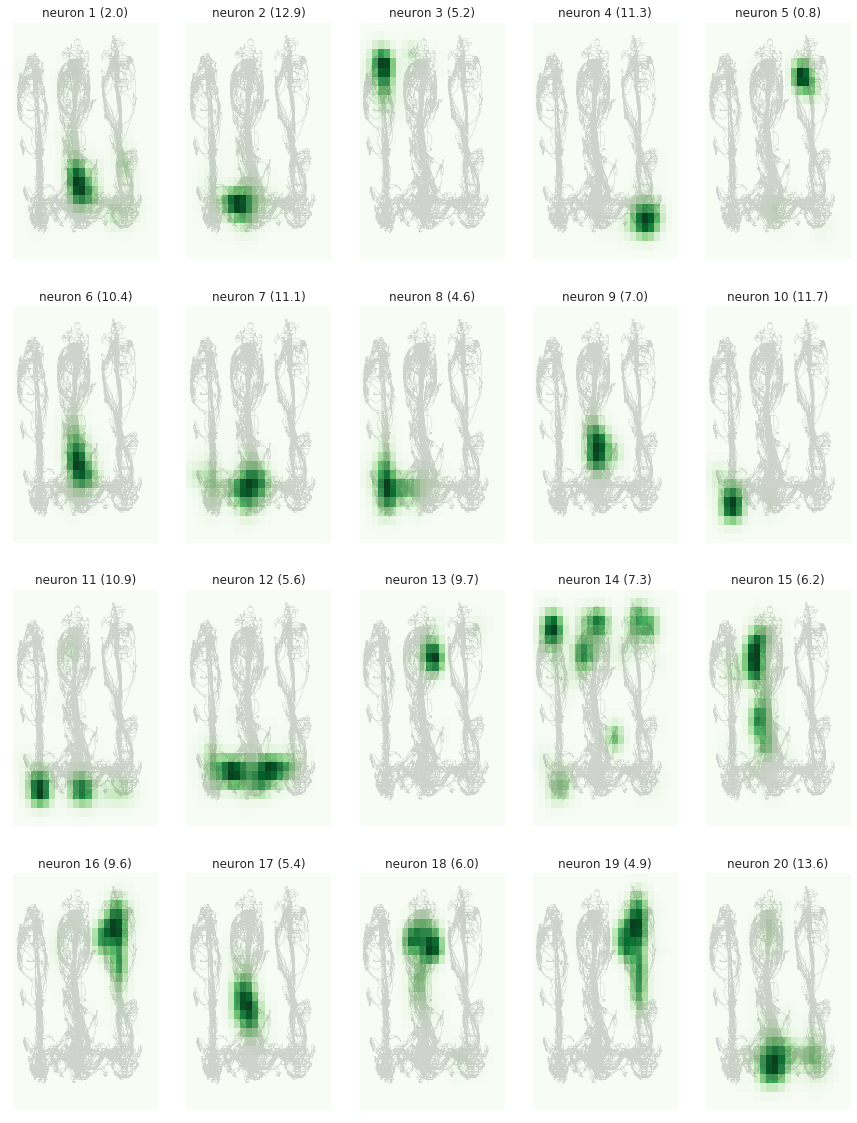

In [20]:
# Plot some placefields

n_units = activeNeurons.shape[0]
with npl.FigureManager(show=True, figsize=(15, 20), nrows=4, ncols=5) as (fig, axes):
    #npl.utils.skip_if_no_output(fig)
    for ii, ax in enumerate(axes.ravel()):
        if (ii >= n_units):
            break
        placefield = ratemap[ii].T
        ax, img = npl.imagesc(x=tc.xbin_centers, y=tc.ybin_centers, 
                              data=placefield,
                              cmap=plt.cm.Greens,
                              ax=ax)
        ax.plot(xvals, yvals, lw=0.5, c='0.2', alpha=0.2)
        ax.set_title('neuron {} ({:3.1f})'.format(ii+1, placefield.max()))
        npl.utils.clear_left_right(ax)
        npl.utils.clear_top_bottom(ax)

In [21]:
# Set up pieces. We're going to work with a spatial matrix for convenience
#   - uniform prior on space
uniformPrior = np.log(np.ones(ratemap.shape[1:]) / np.prod(ratemap.shape[1:]))

# Initialize container for T by nx by ny decoding probability
probData = np.zeros(((Q.data.shape[1],) + ratemap.shape[1:])) # This is going to be T by nx by ny

# Calculate probability term that doesn't depend on the observed spikes and broadcast across time dimension
probData = probData - np.sum(ratemap * ds_run, axis=0) # exp(-\lambda * dT)

In [22]:
# Next calculate term that does depend on observed spikes
#  Q is N x T, ratemap is N x nx x ny - let's do a tensor multiply by that first axis
probData += np.tensordot(Q.data, np.log(ratemap + 0.0001), axes=(0,0))


In [23]:
# Finally, add prior and go from log-probability to probability
p = np.exp(probData + uniformPrior) # again rely on broadcasting

p = (p.T / np.sum(np.sum(p,axis=2),axis=1)).T # normalize to get probabilities. transposes enable broadcasting


#p(nActiveNeurons < 1,:) = 0; % ignore time bins with no activity

Now we want to display the results. Before we do so, we should convert the rat's actual position into our binned form, so that we can compare it to the decoded estimate. We can again use the nifty `at` flag in `asarray()`. 

In [24]:
# Get positions at decoding times
_, pos_true_decode = pos.asarray(at=Q.bin_centers)


## Visualizing decoder output

Now we can visualize the decoding, shown here as a movie (see below for the code):

In [25]:
from IPython.display import HTML
HTML('<iframe width="560" height="315" src="https://www.youtube.com/embed/xTNpmtuimOE?rel=0&amp;controls=0&amp;showinfo=0" frameborder="0" allowfullscreen></iframe>')

/home/ckemere/anaconda3/lib/python3.7/site-packages/IPython/core/display.py:694: UserWarning: Consider using IPython.display.IFrame instead


You can see the rat's true location, rendered as a yellow circle, moving around in the continuous-alternation pattern characteristic of the "W"-maze.  The output of the decoder is plotted using the "seismic" colormap, with red colors corresponding to maximum probability. You should see that as the rat runs along the track, the decoder output tends to follow the rat's true location. In other words, based on neural activity in a given time bin, we can infer the location of the rat.

Note that there are times, especially when the rat is at the ends of the arms, when the decoding is particularly off. Why might this be? (Note that we have not restricted data for decoding to only running periods!)

Also note that in the Karlsson, Frank [2008](http://www.jneurosci.org/content/28/52/14271.short) and [2009](https://www.nature.com/neuro/journal/v12/n7/full/nn.2344.html) papers that use this data, Mattias Karlsson used "linearized" position rather than 2D position. By clamping decoding to a 1D track, quality can be improved!

The code that generates the video is below.

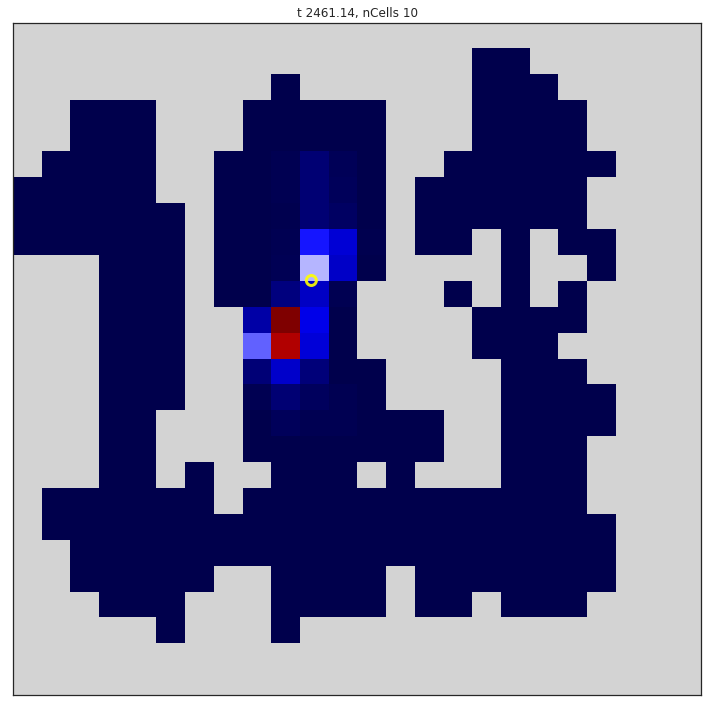

In [26]:
import matplotlib.animation as animation
from matplotlib import colors
from copy import copy

plt.rcParams['animation.ffmpeg_path'] = '/usr/bin/ffmpeg'

dpi = 100

palette = copy(plt.cm.seismic)
palette.set_bad('lightgrey', 1.0)

def update_img(n):
    img.set_data(np.ma.masked_where(tc.occupancy==0,p[n,:,:]).T)
    clist[n] = 'yellow'
    if n >= 2:
        clist[n-2] = 'none'
    points.set_edgecolor(clist)
    ax.set_title('t {:6.2f}, nCells {}'.format(Q.bin_centers[n], np.sum(Q.data[:,n]>0)))
    return img

with npl.FigureManager(show=True, figsize=(10, 10)) as (fig, ax):
    ax.set_aspect('equal')
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    ax, img = npl.imagesc(x=tc.xbin_centers, y=tc.ybin_centers, 
      data=np.ma.masked_where(tc.occupancy==0,p[0,:,:]).T, cmap=palette, ax=ax)

    points = ax.scatter(pos_true_decode[0,:], pos_true_decode[1,:], marker='o', 
                s=100, lw=3, color='none', edgecolor='none', alpha=0.9)

    ax.set_title('t {:6.2f}, nCells {}'.format(0,0))
    
    clist = []
    for _ in pos_true_decode[0,:]:
        clist.append('none')

    plt.tight_layout()
    
    ani = animation.FuncAnimation(fig,update_img,pos_true_decode.shape[1],interval=30)

    writer = animation.writers['ffmpeg'](fps=33)

    #ani.save('demo.mp4',writer=writer,dpi=dpi) # Uncomment this to generate video


## Quantifying decoding error

The above movie gives a useful visual impression of what the decoder output looks like, and that it roughly seems to track the rat's position. A more systematic approach to evaluating the performance of the decoder is to plot the _error_, i.e. the distance between the actual and decoded positions. The cells below will estimate the decode error and a histogram of error as a function of position.

In [27]:
from numpy import unravel_index

# Decode probabiity maxima as estimated hippocampally-represented location
pnan = p
pnan[:,tc.occupancy==0] = -np.inf # mask areas which have zero occupancy


decodedPosition = []
shape2d = pnan[0,:,:].squeeze().shape
for t in range(pnan.shape[0]):
    decodedPosition.append(list(unravel_index(pnan[0,:,:].squeeze().argmax(),shape2d)))

decodedPosition = np.array(decodedPosition).T

decodeError = np.sum(np.sqrt(np.power(decodedPosition - pos_true_decode,2)),axis=0)
errorSumByPosition,_,_ = np.histogram2d(pos_true_decode[0,:],
                                       pos_true_decode[1,:],
                                       bins=list(tc.bins),
                                       weights=decodeError)
positionOccupancy,_,_ = np.histogram2d(pos_true_decode[0,:],
                                       pos_true_decode[1,:],
                                       bins=list(tc.bins))
decodeAccuracy = errorSumByPosition/positionOccupancy

/home/ckemere/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:23: RuntimeWarning: invalid value encountered in true_divide


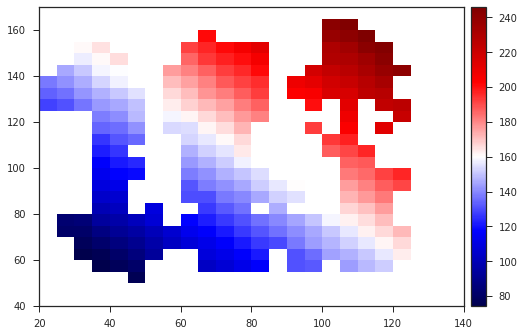

In [28]:
ax, img = npl.imagesc(x=tc.xbin_centers,y=tc.ybin_centers, 
                      data=np.ma.masked_where(tc.occupancy==0,decodeAccuracy).T,
                      cmap=plt.cm.seismic)
from mpl_toolkits.axes_grid1 import make_axes_locatable
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="3.5%", pad=0.1)
cb=plt.colorbar(img, cax=cax)


In this data, the results are not quite as cool as in MVDM's. It looks like the decoding error is on average larger on right side of the maze.

☛ What could be some reasons for this? Can you think of ways to test your suggestions?